In [882]:
import numpy as np
from matplotlib import pyplot as plt
import scipy as sp
from scipy.fftpack import idct


Variable initialization

In [883]:
M = 32 # signal dimension
N = 2 * M # number of atoms in the expansion


C = np.zeros((M, M)) # matrix containing the standard basis (a kronecker delta in each column)
DCT = np.zeros((M, M)) #matrix containing the DCT basis (a DCT function in each column)

Generate the 1D-DCT basis

In [884]:
for i in range(M):
    DCT[:, i] = idct(np.eye(M)[:, i], norm='ortho')


Generating the 1-D standard basis

In [885]:
C = np.eye(M)

Define the dictionary $D = [DCT, C]$

Text(0.5, 1.0, 'Our dictionary M = 32, N = 64')

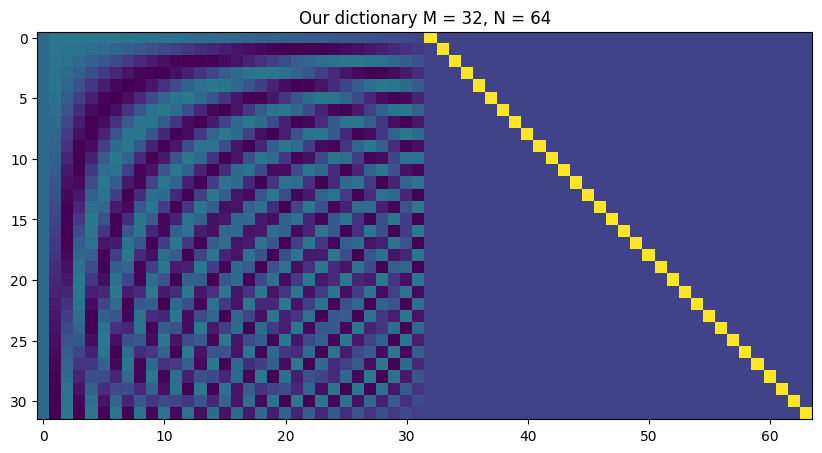

In [886]:
D = np.hstack((DCT, C))

plt.figure(figsize=(10,10))
plt.imshow(D)
plt.title(f'Our dictionary M = {M}, N = {N}')

Generate a signal that is sparse w.r.t. $D$
-----------------------------------------
To this purpose add a spike to the sum of few DCT atoms, i.e., add a spike to s that is sparse w.r.t. D. Bear in mind that the spike is to be considered a signal to be reconstructed, rather than noise

In [887]:
L = 4
sigma_noise = 0.2

Randomly define the coefficients of a sparse representation w.r.t. $D$ (make sure the nonzero coefficients are sufficiently large)

In [888]:
x0 = np.zeros((N, 1))

Choose spike location

In [889]:
spikeLocation = np.random.choice(N, L, replace=False)
x0[spikeLocation] = np.random.randn(L, 1)

Synthetize the corresponding signal in the signal domain and add noise


In [890]:
s0 = D @ x0
s = s0 + sigma_noise * np.random.randn(M, 1)

Plot the sparse signal

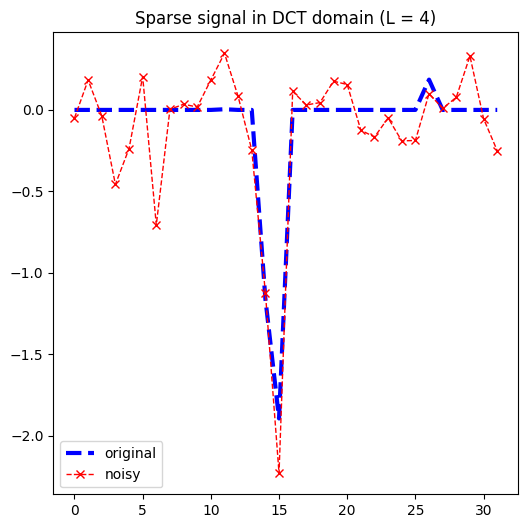

In [891]:
LN_WDT = 2
MRK_SZ = 10

plt.figure(figsize=(6, 6))
plt.plot(s0, 'b--', linewidth=LN_WDT+1)
plt.plot(s, 'r--x', linewidth=LN_WDT-1)
plt.title(f'Sparse signal in DCT domain (L = {L:.0f})')
plt.legend(['original', 'noisy'])


Orthogonal Matching Pursuit
---------------------------

Initialize all the variables, including the residual, namely the components of the signals that can not be represented (here the signal at the very beginning)

In [892]:
x_OMP = np.zeros((N, 1))

# residual
r = s.copy()

# support set
omega = []

MINIMUM_NORM_RES = 0.1

OMP loop starts.

Stoppint criteria: continue until the sparsity of the representation reaches L

In [893]:
while np.count_nonzero(x_OMP) < L and np.linalg.norm(r, 2) > MINIMUM_NORM_RES:

    # SWEEP STEP: look for the column of D that matches at best noisySignal
    # compute the residual w.r.t. each column of D
    e = np.zeros(N)
    for j in range(N):
        e[j] = np.linalg.norm(r, 2)**2 - (r.T @ D[:,j])**2 / np.linalg.norm(D[:, j], 2)**2

    # find the column of D that matches at best r
    jStar = np.argmin(e)

    # UPDATE the support set with the jStar coefficient
    if jStar not in omega:
        omega.append(jStar)

    # update the coefficients by solving the least square problem min ||D_omega x - s ||
    x_OMP[omega] = np.linalg.inv((D[:, omega].T @ D[:, omega])) @ D[:, omega].T @ s

    # update the residual
    r = s - D @ x_OMP


C:\Users\camil\AppData\Local\Temp\ipykernel_17636\1935667303.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  e[j] = np.linalg.norm(r, 2)**2 - (r.T @ D[:,j])**2 / np.linalg.norm(D[:, j], 2)**2


SYNTHESIS: reconstruct the signal, by inverting the transformation to reconstruct the signal

In [894]:
s_hat_OMP = D @ x_OMP

Show the result

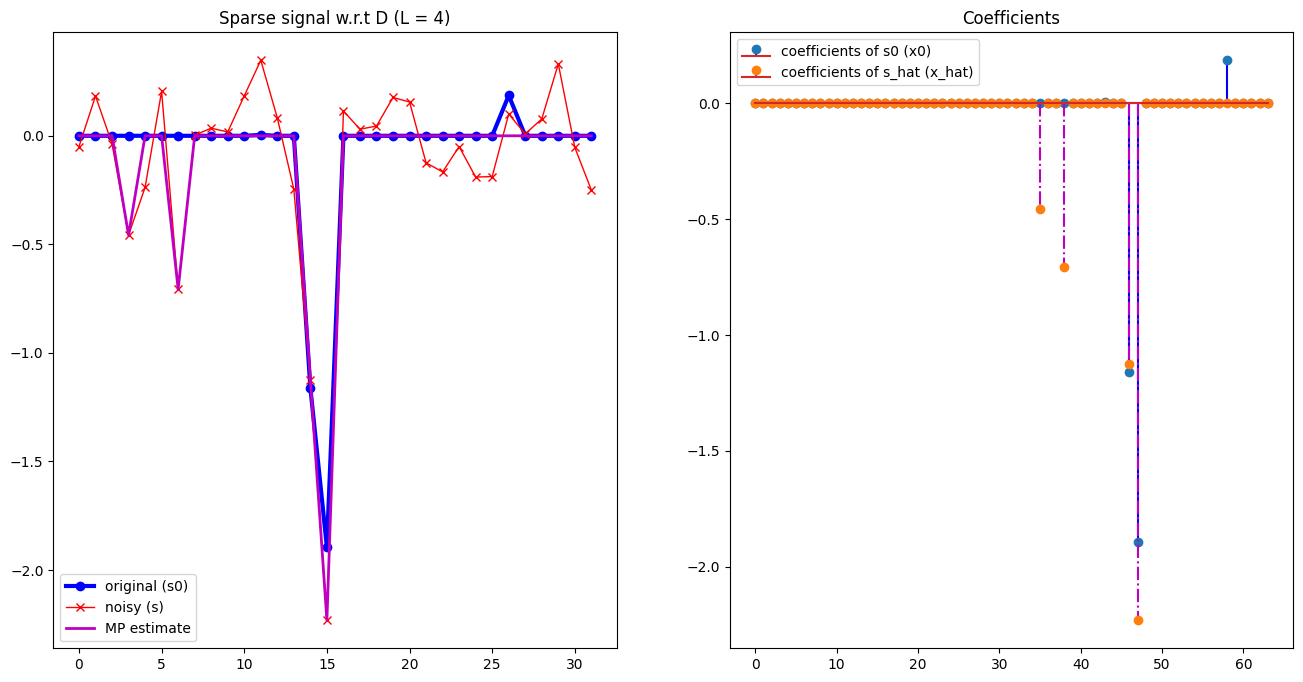

In [895]:
LN_WDT = 2
MRK_SZ = 10

fix, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].plot(s0, 'b-o', linewidth=LN_WDT + 1)
ax[0].plot(s, 'r-x', linewidth=LN_WDT - 1)
ax[0].plot(s_hat_OMP, 'm-', linewidth=LN_WDT)
ax[0].set_title(f'Sparse signal w.r.t D (L = {L:.0f})')
ax[0].legend(['original (s0)', 'noisy (s)', 'MP estimate'])

ax[1].stem(x0, linefmt='b-', markerfmt='C0o')
ax[1].stem(x_OMP, linefmt='m-.', markerfmt='C1o')
ax[1].set_title('Coefficients')
ax[1].legend(['coefficients of s0 (x0)', 'coefficients of s_hat (x_hat)'])

Least Squares Orthogonal Matching Pursuit
-----------------------------------------

Initialize all the variables, including the residual, namely the components of the signals that can not be represented (here the signal at the very beginning)

In [896]:
x_LSOMP = np.zeros((N, 1))

# residual
r = s.copy()

# support set
omega = []

MINIMUM_NORM_RES = 0.1

In [897]:
def fullprint(*args, **kwargs):
    from pprint import pprint
    import numpy
    opt = numpy.get_printoptions()
    numpy.set_printoptions(threshold=numpy.inf)
    pprint(*args, **kwargs)
    numpy.set_printoptions(**opt)

LSOMP loop starts.

Stoppint criteria: continue until the sparsity of the representation reaches L

In [898]:
while np.count_nonzero(x_LSOMP) < L and np.linalg.norm(r, 2) > MINIMUM_NORM_RES:
    # SWEEP STEP: find the best column by solving the LS problem
    if len(omega) == 0:
        # at the first iteration perform the usual sweep step
        e = np.zeros(N)
        for j in range(N):
            e[j] = np.linalg.norm(r, 2)**2 - (r.T @ D[:,j])**2 / np.linalg.norm(D[:, j], 2)**2

        # find the column of D that matches at best r
        jStar = np.argmin(e)
        omega.append(jStar)
        
        x_LSOMP[jStar] += (r.T @ D[:, jStar]) / np.linalg.norm(D[:, jStar], 2)**2
        print(jStar)
    else:
        e = np.full(N, float('inf'))
        for j in range(N):
            if j not in omega:
                D_omega_d_j = np.hstack((D[:,omega],D[:,j].reshape((-1,1))))
                matrix_1 = D_omega_d_j.T @ D_omega_d_j
                matrix_2 = D_omega_d_j.T @ s
                try:
                    result_z_u = np.linalg.inv(matrix_1) @ matrix_2
                except np.linalg.LinAlgError:
                    print(j)
                    # fullprint(D_omega_d_j)
                    # print(matrix_1)
                    # print(D[:,j])
                    raise np.linalg.LinAlgError
                e[j] = np.linalg.norm((s - D_omega_d_j @ result_z_u), 2)**2
            
        # perform the sweep step by solving the LS problem
        jStar = np.argmin(e)
        
    
        D_omega_d_j = np.hstack((D[:,omega],D[:,jStar].reshape((-1,1))))
        matrix_1 = D_omega_d_j.T @ D_omega_d_j
        matrix_2 = D_omega_d_j.T @ s
        result_z_u = np.linalg.inv(matrix_1) @ matrix_2
        
        # UPDATE the support set with the jStar coefficient
        if jStar not in omega:
            omega.append(jStar)
            
            
        # update the coefficients
        x_LSOMP[omega] = result_z_u
        
    # update the residual
    r = s - D @ x_LSOMP



47
(2, 1)
(3, 1)
(4, 1)


C:\Users\camil\AppData\Local\Temp\ipykernel_17636\2525572762.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  e[j] = np.linalg.norm(r, 2)**2 - (r.T @ D[:,j])**2 / np.linalg.norm(D[:, j], 2)**2


In [899]:
x_LSOMP

array([[ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.47847258],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [-0.67769886],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0

SYNTHESIS: reconstruct the signal, by inverting the transformation to reconstruct the signal

In [900]:
s_hat_LSOMP = D @ x_LSOMP

Show the result

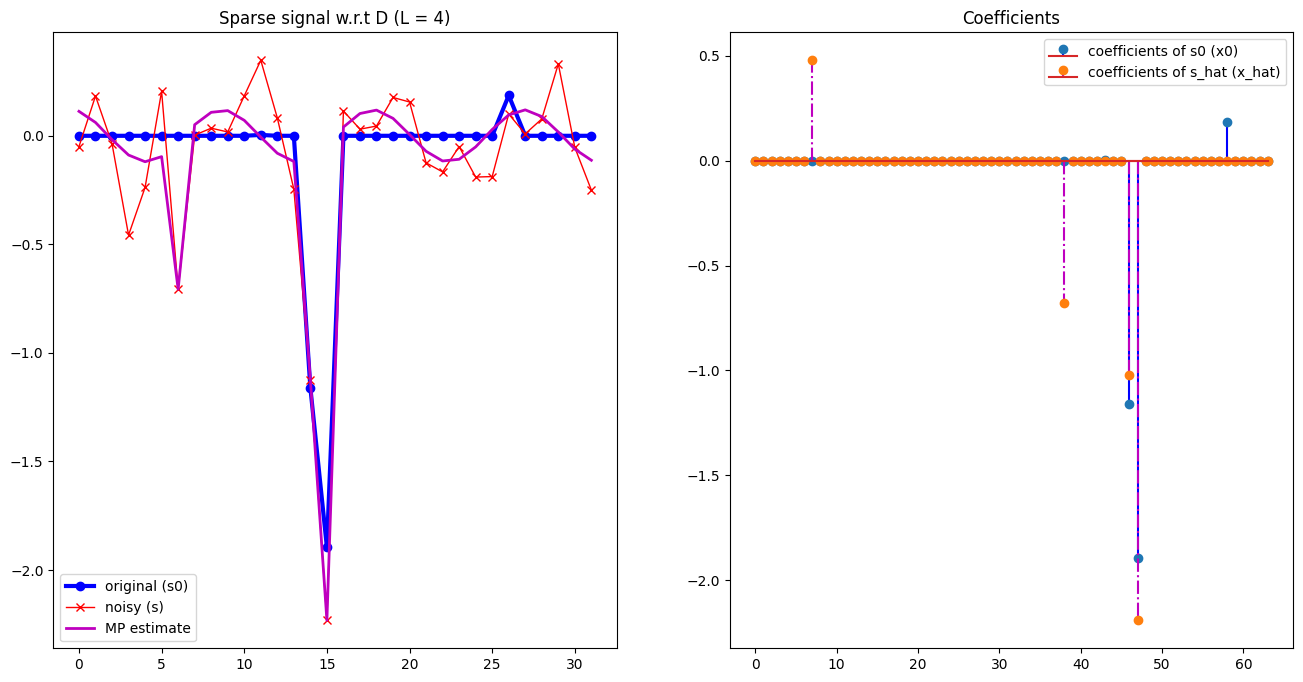

In [901]:
LN_WDT = 2
MRK_SZ = 10

fix, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].plot(s0, 'b-o', linewidth=LN_WDT + 1)
ax[0].plot(s, 'r-x', linewidth=LN_WDT - 1)
ax[0].plot(s_hat_LSOMP, 'm-', linewidth=LN_WDT)
ax[0].set_title(f'Sparse signal w.r.t D (L = {L:.0f})')
ax[0].legend(['original (s0)', 'noisy (s)', 'MP estimate'])

ax[1].stem(x0, linefmt='b-', markerfmt='C0o')
ax[1].stem(x_LSOMP, linefmt='m-.', markerfmt='C1o')
ax[1].set_title('Coefficients')
ax[1].legend(['coefficients of s0 (x0)', 'coefficients of s_hat (x_hat)'])